In [2]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Kolkata'  # to set timezone; needed when running on cloud
time.tzset()

AttributeError: module 'time' has no attribute 'tzset'

In [5]:
params = {
    "batch_size": 2,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 1
}

iter_changes = "dropout_layers_0.4_0.4"

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [6]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [7]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [8]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    print("debugs", dim_0)
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [9]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.decomposition as dec
import scipy as sp
import numpy as np
import csv
stime = time.time()
tqdm_notebook.pandas('Processing...')
stocks = ['AAPL']
daily_dates = ['timestamp', '2019-05-31''2019-05-30''2019-05-29''2019-05-28','2019-05-27','2019-05-26',
         '2019-05-25','2019-05-24','2019-05-23','2019-05-22', '2019-05-21', '2019-05-20', '2019-05-19', 
         '2019-05-18','2019-05-17','2019-05-15','2019-05-15', '2019-05-14', '2019-05-13', '2019-05-12',
         '2019-05-11','2019-05-10','2019-05-09','2019-05-08', '2019-05-07', '2019-05-06', '2019-05-05','2019-05-04', 
         '2019-05-03','2019-05-01','2019-05-01'
               
         '2019-04-30''2019-04-29''2019-04-28','2019-04-27','2019-04-26',
         '2019-04-25','2019-04-24','2019-04-23','2019-04-22', '2019-04-21', '2019-04-20', '2019-04-19', 
         '2019-04-18','2019-04-17','2019-04-15','2019-04-15', '2019-04-14', '2019-04-13', '2019-04-12',
         '2019-04-11','2019-04-10','2019-04-09','2019-04-08', '2019-04-07', '2019-04-06', '2019-04-05','2019-04-04', 
         '2019-04-03','2019-04-01','2019-04-01' 
               
               '2019-03-29''2019-03-28', '2019-03-27', '2019-03-26',
         '2019-03-25','2019-03-24','2019-03-23','2019-03-22', '2019-03-21', '2019-03-20', '2019-03-19', 
         '2019-03-18','2019-03-17','2019-03-15','2019-03-15', '2019-03-14', '2019-03-13', '2019-03-12',
         '2019-03-11','2019-03-10','2019-03-09','2019-03-08', '2019-03-07', '2019-03-06', '2019-03-05','2019-03-04', 
         '2019-03-03','2019-03-01','2019-03-01'
               
         '2019-02-28','2019-02-27','2019-02-26',
         '2019-02-25','2019-02-24','2019-02-23','2019-02-22', '2019-02-21', '2019-02-20', '2019-02-19', 
         '2019-02-18','2019-02-17','2019-02-15','2019-02-15', '2019-02-14', '2019-02-13', '2019-02-12',
         '2019-02-11','2019-02-10','2019-02-09','2019-02-08', '2019-02-07', '2019-02-06', '2019-02-05','2019-02-04', 
         '2019-02-03','2019-02-01','2019-02-01'
              
         '2019-01-31''2019-01-30''2019-01-29''2019-01-28','2019-01-27','2019-01-26',
         '2019-01-25','2019-01-24','2019-01-23','2019-01-22', '2019-01-21', '2019-01-20', '2019-01-19', 
         '2019-01-18','2019-01-17','2019-01-15','2019-01-15', '2019-01-14', '2019-01-13', '2019-01-12',
         '2019-01-11','2019-01-10','2019-01-09','2019-01-08', '2019-01-07', '2019-01-06', '2019-01-05','2019-01-04', 
         '2019-01-03','2019-01-01','2019-01-01' ]

for stock in stocks:
    ts = TimeSeries(key='TTZNA7B3VCDYYHNZ', output_format='csv')
    data, meta_data = ts.get_daily_adjusted(stock, outputsize='full')
    with open('{}-daily-prices.csv'.format(stock), mode='w+', newline='') as my_file:
        for row in data:
            if row[0] in daily_dates:
                wr = csv.writer(my_file, quoting=csv.QUOTE_ALL)
                wr.writerow(row)

In [8]:
#import os
#print(os.listdir("../Desktop/finalproject"))

In [9]:
#df = pd.read_csv("../Desktop/finalproject/AAPL-daily-prices.csv")

In [10]:
df = pd.read_csv("../Downloads/AAPL-daily-prices.csv")

In [11]:
df = df.drop(["adjusted_close", "dividend_amount", "split_coefficient"], axis=1)

In [12]:
df

,timestamp,open,high,low,close,volume
0,2019-05-24,180.200,182.1400,178.6200,178.97,23714686
1,2019-05-23,179.800,180.5400,177.8100,179.66,36529736
2,2019-05-22,184.660,185.7100,182.5500,182.78,29748556
3,2019-05-21,185.220,188.0000,184.7000,186.60,28364848
4,2019-05-20,183.520,184.3490,180.2839,183.09,38612290
5,2019-05-17,186.930,190.9000,186.7600,189.00,32879090
6,2019-05-15,186.270,191.7500,186.0200,190.92,26544718
7,2019-05-14,186.410,189.7000,185.4100,188.66,36529677
8,2019-05-13,187.710,189.4800,182.8500,185.72,57430623
9,2019-05-10,197.419,198.8500,192.7700,197.18,41208712


In [13]:
train_cols = ["open","high","low","close","volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))


Train and Test size 68 17


In [14]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [15]:
print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)


Deleting unused dataframes of total size(KB) 18


In [16]:
print("checking if any null values are present\n", df.isna().sum())
x_t, y_t = build_timeseries(x_train,3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

checking if any null values are present
 timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
debugs 67
dim_0 67



length of time-series i/o (67, 1, 5) (67,)
Batch trimmed size (66, 1, 5) (66,)


In [17]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [18]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Loaded saved model...


In [19]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
print(x_temp)

debugs 16
dim_0 16



length of time-series i/o (16, 1, 5) (16,)
Test size (8, 1, 5) (8,) (8, 1, 5) (8,)
[[[-0.03770883  0.02228443 -0.0272662   0.04300567  0.30205699]]

 [[-0.04844869 -0.03762598 -0.05955513 -0.06876181  0.32660948]]

 [[-0.32243437 -0.2806271  -0.33723989 -0.27575614  0.34503092]]

 [[-0.35513126 -0.36237402 -0.39894762 -0.39532136  0.17528985]]

 [[-0.35417661 -0.34759239 -0.39990433 -0.36649338  0.1268996 ]]

 [[-0.30023866 -0.31198208 -0.37790002 -0.38114367  0.27899002]]

 [[-0.27422434 -0.2862262  -0.29752212 -0.29796786  0.34928432]]

 [[-0.35298329 -0.29115342 -0.36259268 -0.32065217  0.26699579]]

 [[-0.44677804 -0.38678611 -0.43936857 -0.38657845  0.24373567]]

 [[-0.43293556 -0.43426652 -0.45922028 -0.45912098  0.32181539]]

 [[-0.38448687 -0.37984323 -0.4044487  -0.40500945  0.20840936]]

 [[-0.39355609 -0.37379619 -0.41999522 -0.36932892  0.39178368]]

 [[-0.42243437 -0.3612542  -0.44941402 -0.38090737  0.58690457]]

 [[-0.46372315 -0.42194849 -0.47596269 -0.44139887  0.5016

In [20]:
OUTPUT_PATH="C:\\Users\\robsm\\Downloads"

In [21]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger('training.log')
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Building model...
checking if GPU available []
Train on 66 samples, validate on 8 samples
Epoch 1/300
 - 2s - loss: 0.0957 - val_loss: 0.6664

Epoch 00001: val_loss improved from inf to 0.66635, saving model to C:\Users\robsm\Downloads\best_model.h5
Epoch 2/300
 - 0s - loss: 0.0954 - val_loss: 0.6639

Epoch 00002: val_loss improved from 0.66635 to 0.66392, saving model to C:\Users\robsm\Downloads\best_model.h5
Epoch 3/300
 - 0s - loss: 0.0952 - val_loss: 0.6614

Epoch 00003: val_loss improved from 0.66392 to 0.66139, saving model to C:\Users\robsm\Downloads\best_model.h5
Epoch 4/300
 - 0s - loss: 0.0948 - val_loss: 0.6587

Epoch 00004: val_loss improved from 0.66139 to 0.65871, saving model to C:\Users\robsm\Downloads\best_model.h5
Epoch 5/300
 - 0s - loss: 0.0944 - val_loss: 0.6557

Epoch 00005: val_loss improved from 0.65871 to 0.65570, saving model to C:\Users\robsm\Downloads\best_model.h5
Epoch 6/300
 - 0s - loss: 0.0940 - val_loss: 0.6527

Epoch 00006: val_loss improved from 0.655

In [22]:
from keras.layers import Input, Flatten
from keras.models import Model

y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.8020460430778629 (8,) (8,)
[0.27486265 0.25210738 0.38282984 0.35593966 0.49367544 0.46094504
 0.56103826 0.5385169 ]
[-0.45912098 -0.40500945 -0.36932892 -0.38090737 -0.44139887 -0.50803403
 -0.50023629 -0.6436673 ]


In [23]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[181.06218 180.09918 185.63135 184.49336 190.32234 188.9372  193.17313
 192.22003]
[150.   152.29 153.8  153.31 150.75 147.93 148.26 142.19]


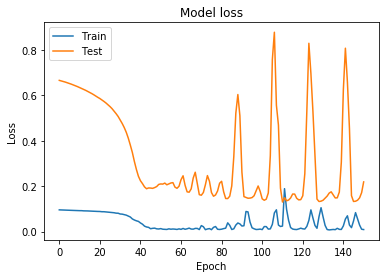

In [25]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_.png'))


In [26]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [27]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.6438510064176715 (8,) (8,)
[0.40923783 0.40643197 0.3638909  0.3608959  0.31752944 0.31151032
 0.266797   0.25881553]
[-0.45912098 -0.40500945 -0.36932892 -0.38090737 -0.44139887 -0.50803403
 -0.50023629 -0.6436673 ]
[186.74893 186.63019 184.82985 184.70311 182.86784 182.61311 180.72084
 180.38307]
[150.   152.29 153.8  153.31 150.75 147.93 148.26 142.19]


program completed  3.0 minutes :  39.0 seconds


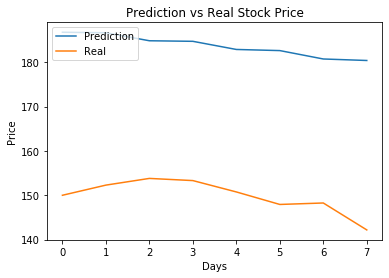

In [30]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS.png'))
print_time("program completed ", stime)